# Gensim Word2Vec Tutorial

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
df = pd.read_csv('../input/simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

Removing the missing values:

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [6]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [7]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [8]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.2 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(92412, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [10]:
from gensim.models.phrases import Phrases, Phraser

INFO - 15:54:48: 'pattern' package not found; tag filters are not available for English


As `Phrases()` takes a list of list of words as input:

In [11]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [12]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:54:56: collecting all words and their counts
INFO - 15:54:56: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:54:56: PROGRESS: at sentence #10000, processed 67396 words and 50551 word types
INFO - 15:54:57: PROGRESS: at sentence #20000, processed 140465 words and 95808 word types
INFO - 15:54:57: PROGRESS: at sentence #30000, processed 207950 words and 132011 word types
INFO - 15:54:57: PROGRESS: at sentence #40000, processed 270207 words and 164407 word types
INFO - 15:54:57: PROGRESS: at sentence #50000, processed 334085 words and 196195 word types
INFO - 15:54:57: PROGRESS: at sentence #60000, processed 400877 words and 228659 word types
INFO - 15:54:58: PROGRESS: at sentence #70000, processed 467802 words and 260712 word types
INFO - 15:54:58: PROGRESS: at sentence #80000, processed 534361 words and 292095 word types
INFO - 15:54:58: PROGRESS: at sentence #90000, processed 602037 words and 321944 word types
INFO - 15:54:58: collected 328658 word typ

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [13]:
bigram = Phraser(phrases)

INFO - 15:55:03: source_vocab length 328658
INFO - 15:55:08: Phraser built with 127 phrasegrams


Transform the corpus based on the bigrams detected:

In [14]:
sentences = bigram[sent]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [15]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29673

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['be', 'not', 'oh', 'will', 'like', "'s", 'know', 'think', 'hey', 'good']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [19]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [20]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:55:39: collecting all words and their counts
INFO - 15:55:39: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:55:39: PROGRESS: at sentence #10000, processed 65193 words, keeping 9096 word types
INFO - 15:55:40: PROGRESS: at sentence #20000, processed 136024 words, keeping 13916 word types
INFO - 15:55:40: PROGRESS: at sentence #30000, processed 201577 words, keeping 16865 word types
INFO - 15:55:40: PROGRESS: at sentence #40000, processed 262082 words, keeping 19506 word types
INFO - 15:55:41: PROGRESS: at sentence #50000, processed 324069 words, keeping 21758 word types
INFO - 15:55:41: PROGRESS: at sentence #60000, processed 388895 words, keeping 23910 word types
INFO - 15:55:42: PROGRESS: at sentence #70000, processed 454042 words, keeping 25876 word types
INFO - 15:55:42: PROGRESS: at sentence #80000, processed 518929 words, keeping 27769 word types
INFO - 15:55:42: PROGRESS: at sentence #90000, processed 584755 words, keeping 29345 word types


Time to build vocab: 0.06 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [21]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:55:43: training model with 3 workers on 3375 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:55:44: EPOCH 1 - PROGRESS: at 25.38% examples, 55904 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:45: EPOCH 1 - PROGRESS: at 53.41% examples, 55866 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:46: EPOCH 1 - PROGRESS: at 78.38% examples, 54732 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:47: worker thread finished; awaiting finish of 2 more threads
INFO - 15:55:47: worker thread finished; awaiting finish of 1 more threads
INFO - 15:55:47: worker thread finished; awaiting finish of 0 more threads
INFO - 15:55:47: EPOCH - 1 : training on 601119 raw words (219268 effective words) took 4.0s, 55056 effective words/s
INFO - 15:55:48: EPOCH 2 - PROGRESS: at 20.71% examples, 46049 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:49: EPOCH 2 - PROGRESS: at 48.35% examples, 50317 words/s, in_qsize 0, out_qsize 0
INFO - 15:55:50: EPOCH 2 - PROGRESS: at 71.

Time to train the model: 2.0 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [22]:
w2v_model.init_sims(replace=True)

INFO - 15:57:43: precomputing L2-norms of word weight vectors


# Exploring the model
## Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/02/Homer_Simpson_2006.png/revision/latest?cb=20091207194310" alt="drawing" width="130"/>

Let's see what we get for the show's main character:

In [23]:
w2v_model.wv.most_similar(positive=["homer"])

/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('depressed', 0.7349528074264526),
 ('marge', 0.6926991939544678),
 ('terrific', 0.6696251630783081),
 ('hammock', 0.6627354621887207),
 ('bongo', 0.6586619019508362),
 ('asleep', 0.650829553604126),
 ('sweetheart', 0.6474747657775879),
 ('dr_hibbert', 0.6455447673797607),
 ('fault', 0.6434005498886108),
 ('crummy', 0.6429384350776672)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [24]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('pleased', 0.6999630928039551),
 ('select', 0.6936435699462891),
 ('client', 0.6913710832595825),
 ('governor', 0.6747652292251587),
 ('current', 0.6727321147918701),
 ('hutz', 0.670383095741272),
 ('easily', 0.6702475547790527),
 ('kidnap', 0.6689953207969666),
 ('sir', 0.6685984134674072),
 ('threat', 0.6667574644088745)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>

What about Marge now?

In [25]:
w2v_model.wv.most_similar(positive=["marge"])

[('homie', 0.7089205384254456),
 ('badly', 0.7048567533493042),
 ('grownup', 0.7015737295150757),
 ('homer', 0.6926991939544678),
 ('snuggle', 0.6843920946121216),
 ('arrange', 0.6842201948165894),
 ('fault', 0.6836150884628296),
 ('becky', 0.6798429489135742),
 ('rude', 0.6741777658462524),
 ('husband', 0.6735585927963257)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="100"/>

Let's check Bart now:

In [26]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8318909406661987),
 ('dr_hibbert', 0.7379722595214844),
 ('homework', 0.7350765466690063),
 ('mom', 0.7281243801116943),
 ('mom_dad', 0.7229346036911011),
 ('creepy', 0.7202342748641968),
 ('hearing', 0.7178507447242737),
 ('upset', 0.7162879109382629),
 ('surprised', 0.7053326368331909),
 ('strangle', 0.6990929841995239)]

Looks like it is making sense!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/9d/Groundskeeper_Willie.png/revision/latest?cb=20130424154035" alt="drawing" width="150"/>

Willie the groundskeeper for the last one:

## Similarities:
Here, we will see how similar are two words to each other :

In [27]:
w2v_model.wv.similarity("moe_'s", 'tavern')

0.9190243

Who could forget Moe's tavern? Not Barney.

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/6c/MaggieSimpson.PNG/revision/latest?cb=20180314210204" alt="drawing" width="100"/>

In [28]:
w2v_model.wv.similarity('maggie', 'baby')

0.7036968

Maggie is indeed the most renown baby in the Simpsons!

In [29]:
w2v_model.wv.similarity('bart', 'nelson')

0.5727066

Bart and Nelson, though friends, are not that close, makes sense!

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [30]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

'milhouse'

Milhouse of course!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/91/Milhouse_Van_Houten_2.png/revision/latest?cb=20180429212659" alt="drawing" width="150"/>

What if we compared the friendship between Nelson, Bart, and Milhouse?

In [31]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

Seems like Nelson is the odd one here!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/4/40/Picture0003.jpg/revision/latest?cb=20110623042517" alt="drawing" width="200"/>

Last but not least, how is the relationship between Homer and his two sister-in-laws?

In [32]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

Damn, they really do not like you Homer!

## Analogy difference:
Which word is to woman as homer is to marge?

In [33]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('man', 0.6460278034210205),
 ('people', 0.5691067576408386),
 ('admire', 0.5580703616142273)]

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [34]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.7147189378738403),
 ('surprised', 0.6473562121391296),
 ('parent', 0.6430631279945374)]

Lisa is Bart's sister, her male counterpart!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/5/57/Lisa_Simpson2.png/revision/latest?cb=20180319000458" alt="drawing" width="100"/>

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [36]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


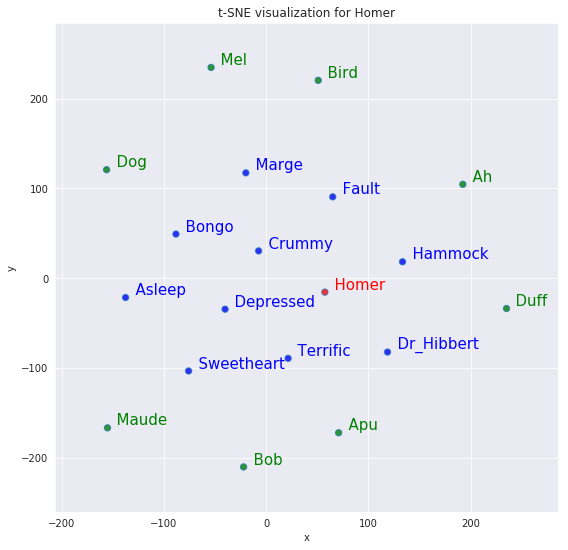

In [37]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

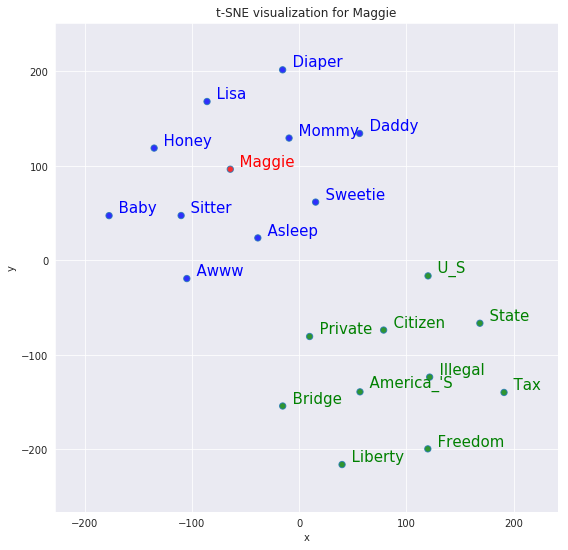

In [38]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

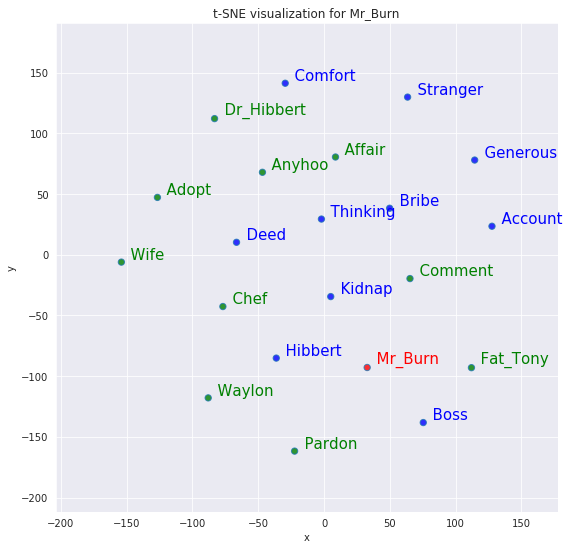

In [39]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])